# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [2]:
import json
import pandas as pd
from decimal import Decimal

# Utils
import src.utils.visualization.gantt_diagram as gantt

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [4]:
# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_data_path = get_path("data", "examples")
logs_path = get_path("data", "logs")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [5]:
jobs = JobQuery.get_by_max_bottleneck_utilization(Decimal("0.85"))
jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,3296
1,01-08500-0016,01-07,1504,2880,5716
2,01-08500-0029,01-07,2352,2880,4598
3,01-08500-0034,01-07,2791,2880,4868
4,01-08500-0047,01-07,3513,4320,5939
5,01-08500-0053,01-07,3949,4320,7604
...,...,...,...,...,...
9598,01-08500-9541,01-08,715701,717120,719546
9599,01-08500-9557,01-08,717245,718560,720391
9600,01-08500-9566,01-08,718254,718560,721760


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [8]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,0,M01-02,None,31,None,1440,3296
1,01-08500-0000,01-07,1,M01-00,None,86,None,1440,3296
2,01-08500-0000,01-07,2,M01-01,None,46,None,1440,3296
3,01-08500-0000,01-07,3,M01-05,None,74,None,1440,3296
4,01-08500-0000,01-07,4,M01-04,None,32,None,1440,3296
5,01-08500-0000,01-07,5,M01-06,None,88,None,1440,3296
...,...,...,...,...,...,...,...,...,...
154,01-08500-0012,01-08,4,M01-02,None,85,None,1440,4116
155,01-08500-0012,01-08,5,M01-09,None,11,None,1440,4116
156,01-08500-0012,01-08,6,M01-06,None,40,None,1440,4116


In [9]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,3296
1,01-08500-0001,01-06,53,1440,2330
2,01-08500-0010,01-06,1002,1440,2738
3,01-08500-0002,01-01,125,1440,3773
4,01-08500-0015,01-01,1437,1440,3198
5,01-08500-0003,01-05,174,1440,3091
6,01-08500-0004,01-04,219,1440,4098
7,01-08500-0013,01-04,1178,1440,2917
8,01-08500-0005,01-02,443,1440,3578
9,01-08500-0011,01-02,1007,1440,2796


### Scheduling

In [10]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,
    active_jobs_collection=None,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

w_t=5, w_e=1, w_first=1 main_pct=1.0
{
  "number_of_operations_to_schedule": 160,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 0,
  "number_of_variables": 421,
  "number_of_constraints": 431
}


In [11]:
log_file_path = logs_path / "cp_lateness_with_w_first_init.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

{
  "status": "OPTIMAL",
  "objective_value": 11.0,
  "best_objective_bound": 11.0,
  "number_of_branches": 0,
  "wall_time": 0.07
}


In [12]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,0,M01-02,2113,31,2144,1440,3296
1,01-08500-0000,01-07,1,M01-00,2144,86,2230,1440,3296
2,01-08500-0000,01-07,2,M01-01,2249,46,2295,1440,3296
3,01-08500-0000,01-07,3,M01-05,2295,74,2369,1440,3296
4,01-08500-0000,01-07,4,M01-04,2369,32,2401,1440,3296
5,01-08500-0000,01-07,5,M01-06,2446,88,2534,1440,3296
...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M01-03,2199,69,2268,1440,3198
155,01-08500-0015,01-01,5,M01-01,2295,28,2323,1440,3198
156,01-08500-0015,01-01,6,M01-06,2323,46,2369,1440,3198


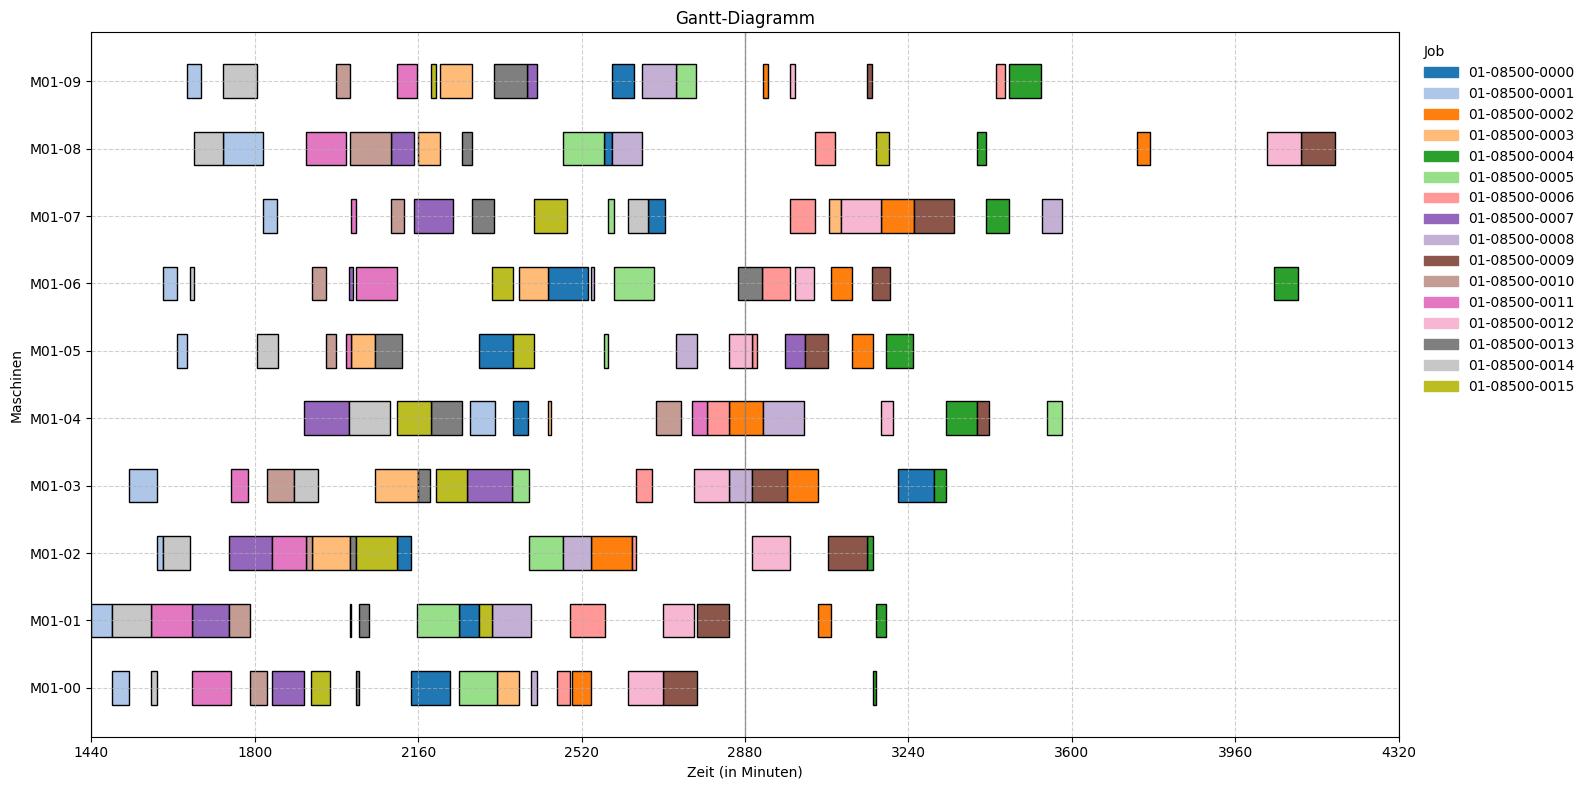

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [13]:
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


In [14]:
df_last_ops = schedule_jobs_collection.to_last_ops_dataframe()
df_last_ops

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline,Total Processing Time
0,01-08500-0000,01-07,9,M01-03,3217,79,3296,1440,3296,539
1,01-08500-0001,01-06,9,M01-04,2275,55,2330,1440,2330,416
2,01-08500-0002,01-01,9,M01-08,3743,30,3773,1440,3773,510
3,01-08500-0003,01-05,9,M01-07,3066,25,3091,1440,3091,496
4,01-08500-0004,01-04,9,M01-06,4045,53,4098,1440,4098,393
5,01-08500-0005,01-02,9,M01-04,3545,33,3578,1440,3578,568
6,01-08500-0006,01-00,9,M01-09,3432,21,3453,1440,3453,395
7,01-08500-0007,01-03,9,M01-05,2969,43,3012,1440,3012,655
8,01-08500-0008,01-09,9,M01-07,3534,45,3579,1440,3579,540
9,01-08500-0009,01-08,9,M01-08,4105,74,4179,1440,4179,597


In [15]:
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_last_ops)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,16,0,0,0


In [16]:
get_jobs_aggregated(df_last_ops_with_metrics, column="Lateness")

Lateness_Interval,<-120,-120 - -60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,1,15,0,0,0


### Simulation

In [17]:
simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job 01-08500-0001 started on M01-01
[Day 1 00:46:00] Job 01-08500-0001 finished on M01-01 (after 46 minutes)
[Day 1 00:46:00] Job 01-08500-0014 started on M01-01
[Day 1 00:46:00] Job 01-08500-0001 started on M01-00
[Day 1 01:22:00] Job 01-08500-0001 finished on M01-00 (after 36 minutes)
[Day 1 01:23:00] Job 01-08500-0001 started on M01-03
[Day 1 02:19:00] Job 01-08500-0001 finished on M01-03 (after 56 minutes)
[Day 1 02:24:00] Job 01-08500-0001 started on M01-02
[Day 1 02:35:00] Job 01-08500-0014 finished on M01-01 (after 109 minutes)
[Day 1 02:35:00] Job 01-08500-0011 started on M01-01
[Day 1 02:35:00] Job 01-08500-0014 started on M01-00
[Day 1 02:39:00] Job 01-08500-0001 finished on M01-02 (after 15 minutes)
[Day 1 02:39:00] Job 01-08500-0001 started on M01-06
[Day 1 02:45:00] Job 01-08500-0014 finished on M01-00 (after 10 minutes)
[Day 1 02:45:00] Job 01-08500-0014 started on M01-02
[Day 1 03:13:00] Job 01-08500-0001 finished on M01-06 (after 34 minutes)
[Day 1 03:1

In [18]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0001,01-06,0,M01-01,1440.0,46.0,1486.0,1440,2330
1,01-08500-0001,01-06,1,M01-00,1486.0,36.0,1522.0,1440,2330
2,01-08500-0001,01-06,2,M01-03,1523.0,56.0,1579.0,1440,2330
3,01-08500-0001,01-06,3,M01-02,1584.0,15.0,1599.0,1440,2330
4,01-08500-0001,01-06,4,M01-06,1599.0,34.0,1633.0,1440,2330
5,01-08500-0001,01-06,5,M01-05,1633.0,14.0,1647.0,1440,2330
...,...,...,...,...,...,...,...,...,...
107,01-08500-0002,01-01,1,M01-02,2606.0,113.0,2719.0,1440,3773
108,01-08500-0012,01-08,0,M01-00,2623.0,74.0,2697.0,1440,4116
109,01-08500-0012,01-08,1,M01-01,2699.0,80.0,2779.0,1440,4116


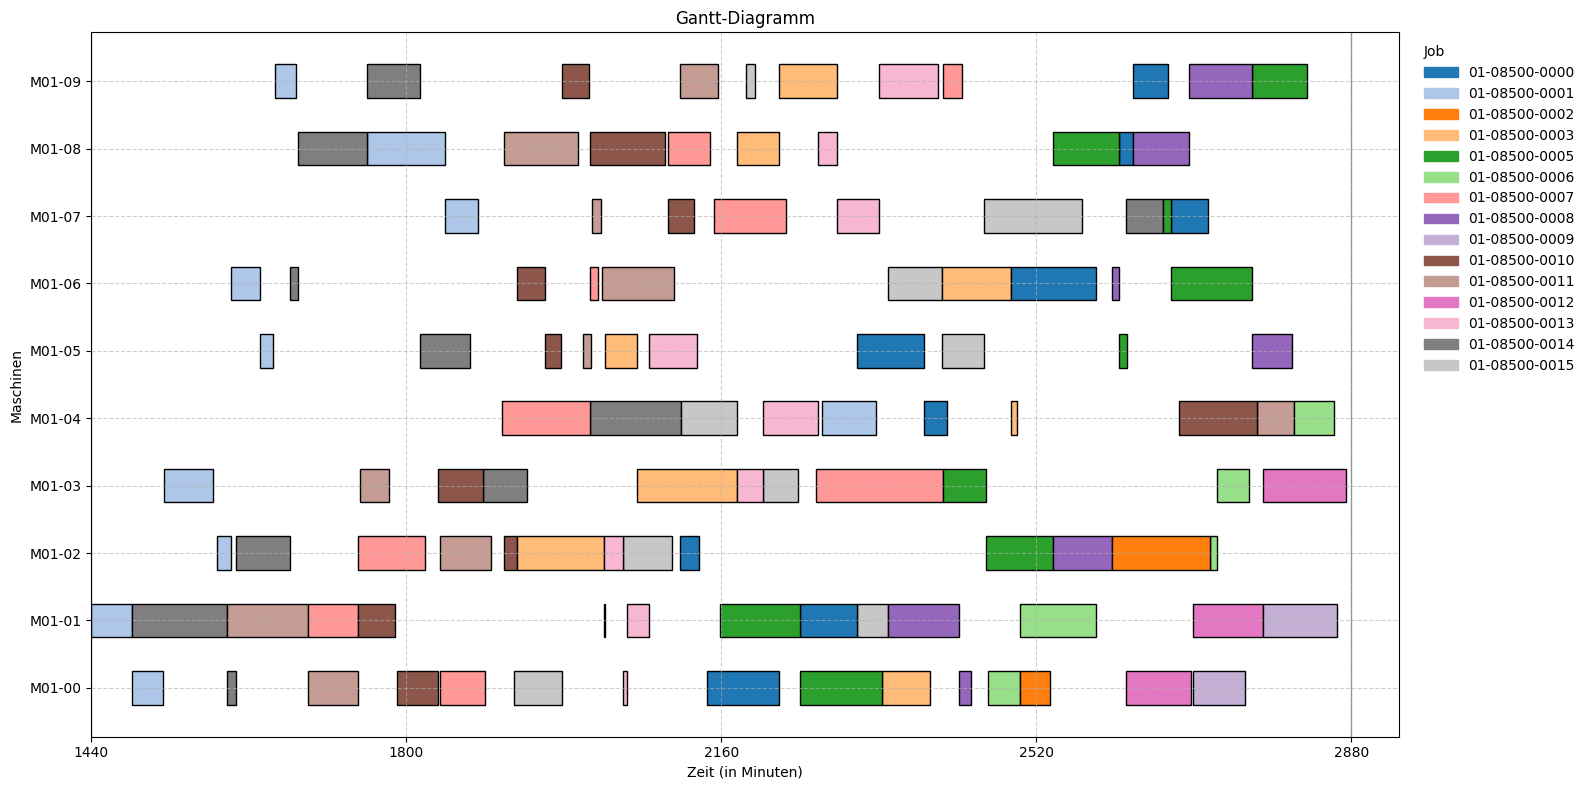

In [19]:
gantt.get_plot(df_execution, perspective="Machine")

In [20]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0002,01-01,2,M01-04,2860.0,75.0,2935.0,1440,3773
1,01-08500-0013,01-04,9,M01-06,2864.0,62.0,2926.0,1440,2917
2,01-08500-0008,01-09,7,M01-03,2874.0,50.0,2924.0,1440,3579
3,01-08500-0012,01-08,3,M01-05,2874.0,46.0,2920.0,1440,4116


In [21]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,9,M01-03,3217,79,3296,1440,3296
1,01-08500-0002,01-01,3,M01-09,2920,11,2931,1440,3773
2,01-08500-0002,01-01,4,M01-03,2972,69,3041,1440,3773
3,01-08500-0002,01-01,5,M01-01,3041,28,3069,1440,3773
4,01-08500-0002,01-01,6,M01-06,3069,46,3115,1440,3773
5,01-08500-0002,01-01,7,M01-05,3115,46,3161,1440,3773
...,...,...,...,...,...,...,...,...,...
37,01-08500-0012,01-08,5,M01-09,2980,11,2991,1440,4116
38,01-08500-0012,01-08,6,M01-06,2991,40,3031,1440,4116
39,01-08500-0012,01-08,7,M01-07,3091,89,3180,1440,4116


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [22]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [23]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [24]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0016,01-07,0,M01-02,None,31,None,2880,5716
1,01-08500-0016,01-07,1,M01-00,None,86,None,2880,5716
2,01-08500-0016,01-07,2,M01-01,None,46,None,2880,5716
3,01-08500-0016,01-07,3,M01-05,None,74,None,2880,5716
4,01-08500-0016,01-07,4,M01-04,None,32,None,2880,5716
5,01-08500-0016,01-07,5,M01-06,None,88,None,2880,5716
...,...,...,...,...,...,...,...,...,...
204,01-08500-0024,01-08,4,M01-02,None,85,None,2880,4765
205,01-08500-0024,01-08,5,M01-09,None,11,None,2880,4765
206,01-08500-0024,01-08,6,M01-06,None,40,None,2880,4765


In [25]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,9,M01-03,3217.0,79,3296.0,1440,3296
1,01-08500-0002,01-01,3,M01-09,2920.0,11,2931.0,1440,3773
2,01-08500-0002,01-01,4,M01-03,2972.0,69,3041.0,1440,3773
3,01-08500-0002,01-01,5,M01-01,3041.0,28,3069.0,1440,3773
4,01-08500-0002,01-01,6,M01-06,3069.0,46,3115.0,1440,3773
5,01-08500-0002,01-01,7,M01-05,3115.0,46,3161.0,1440,3773
...,...,...,...,...,...,...,...,...,...
247,01-08500-0036,01-03,4,M01-06,NaN,9,NaN,2880,4495
248,01-08500-0036,01-03,5,M01-08,NaN,52,NaN,2880,4495
249,01-08500-0036,01-03,6,M01-07,NaN,85,NaN,2880,4495


### Scheduling (Rescheduling)

In [26]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [27]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,         # simple scheduling
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_simple.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))


w_t=5, w_e=1, w_first=1 main_pct=1.0
{
  "number_of_operations_to_schedule": 253,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 4,
  "number_of_variables": 703,
  "number_of_constraints": 717
}
{
  "status": "OPTIMAL",
  "objective_value": 11.0,
  "best_objective_bound": 11.0,
  "number_of_branches": 134,
  "wall_time": 0.18
}


In [28]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_simple.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,9,M01-03,3217,79,3296,1440,3296
1,01-08500-0002,01-01,3,M01-09,3018,11,3029,1440,3773
2,01-08500-0002,01-01,4,M01-03,3029,69,3098,1440,3773
3,01-08500-0002,01-01,5,M01-01,3098,28,3126,1440,3773
4,01-08500-0002,01-01,6,M01-06,3126,46,3172,1440,3773
5,01-08500-0002,01-01,7,M01-05,3391,46,3437,1440,3773
...,...,...,...,...,...,...,...,...,...
247,01-08500-0036,01-03,4,M01-06,3677,9,3686,2880,4495
248,01-08500-0036,01-03,5,M01-08,3686,52,3738,2880,4495
249,01-08500-0036,01-03,6,M01-07,3738,85,3823,2880,4495


In [29]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 23 (over 43 shared operations)
Mean Kendall Tau: 0.44


In [30]:
df_last_ops = schedule_jobs_collection.to_last_ops_dataframe()
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_last_ops)
get_jobs_aggregated(df_last_ops_with_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,31,0,0,0


### b) with 'start' deviation penalty

In [31]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=previous_schedule_jobs_collection,
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    main_pct= (1/3),
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_dev.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

w_t=5, w_e=1, w_first=1 main_pct=0.3333333333333333
{
  "number_of_operations_to_schedule": 253,
  "number_of_operations_with_previous_schedule": 160,
  "number_of_active_operation_to_consider": 4,
  "number_of_variables": 746,
  "number_of_constraints": 760
}
{
  "status": "OPTIMAL",
  "objective_value": 1742.0,
  "best_objective_bound": 1742.0,
  "number_of_branches": 69,
  "wall_time": 0.9
}


In [32]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_dev.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,9,M01-03,3217,79,3296,1440,3296
1,01-08500-0002,01-01,3,M01-09,2935,11,2946,1440,3773
2,01-08500-0002,01-01,4,M01-03,3000,69,3069,1440,3773
3,01-08500-0002,01-01,5,M01-01,3069,28,3097,1440,3773
4,01-08500-0002,01-01,6,M01-06,3097,46,3143,1440,3773
5,01-08500-0002,01-01,7,M01-05,3143,46,3189,1440,3773
...,...,...,...,...,...,...,...,...,...
247,01-08500-0036,01-03,4,M01-06,3865,9,3874,2880,4495
248,01-08500-0036,01-03,5,M01-08,3962,52,4014,2880,4495
249,01-08500-0036,01-03,6,M01-07,4038,85,4123,2880,4495


In [33]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M01-00,[01-08500-0004],[01-08500-0004],0,1.0
M01-01,"[01-08500-0002, 01-08500-0004]","[01-08500-0002, 01-08500-0004]",0,1.0
M01-02,"[01-08500-0012, 01-08500-0009, 01-08500-0004]","[01-08500-0012, 01-08500-0009, 01-08500-0004]",0,1.0
M01-03,"[01-08500-0009, 01-08500-0002, 01-08500-0000, ...","[01-08500-0009, 01-08500-0002, 01-08500-0000, ...",0,1.0
M01-04,"[01-08500-0008, 01-08500-0012, 01-08500-0004, ...","[01-08500-0008, 01-08500-0012, 01-08500-0004, ...",0,1.0
M01-05,"[01-08500-0006, 01-08500-0007, 01-08500-0009, ...","[01-08500-0006, 01-08500-0007, 01-08500-0009, ...",0,1.0
M01-06,"[01-08500-0006, 01-08500-0012, 01-08500-0002, ...","[01-08500-0006, 01-08500-0012, 01-08500-0002, ...",0,1.0
M01-07,"[01-08500-0006, 01-08500-0003, 01-08500-0012, ...","[01-08500-0006, 01-08500-0003, 01-08500-0012, ...",0,1.0
M01-08,"[01-08500-0006, 01-08500-0015, 01-08500-0004, ...","[01-08500-0006, 01-08500-0015, 01-08500-0004, ...",0,1.0


In [34]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 0 (over 43 shared operations)
Mean Kendall Tau: 1.00


In [35]:
df_last_ops = schedule_jobs_collection.to_last_ops_dataframe()
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_last_ops)
get_jobs_aggregated(df_last_ops_with_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,2,29,1,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

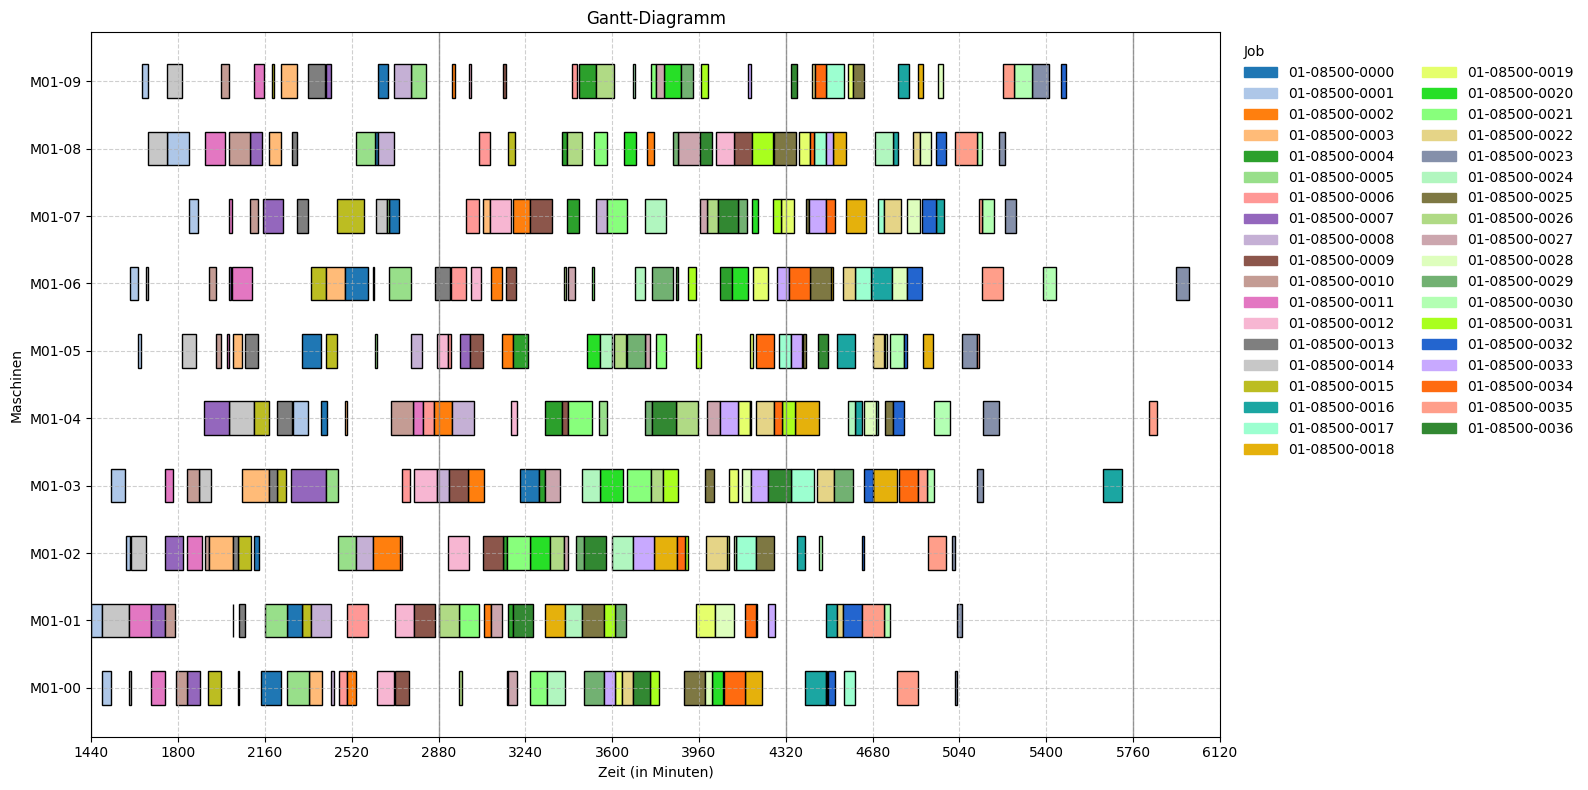

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [36]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

In [37]:
-

SyntaxError: invalid syntax (3457752569.py, line 1)

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)